In [1]:
import os
import soundfile as sf
import librosa
import librosa.display as dsp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
max_wart = 39.012882232666016
min_wart = -72.86720275878906

In [3]:
# Pobranie wszystkich osób z wav i utworzenie dla każdej folderu oraz stworzenie nparray o rozmiarze (90, 173)

source_path = "zebrane"
dest_path = "zebrane_prepared"
# wav_file = "audioFile.wav"

person_count = 0
persons_limit = len(os.listdir(source_path))

for person in os.listdir(source_path):
    person_count += 1
    file_count = 0
    
    if os.path.isdir(dest_path + '/' + person[:-4]) == False:
        os.mkdir(dest_path + '/' + person[:-4])
        
    count = 0
    
    data, sample_rate = librosa.load(f'{source_path}/{person}')
    
    mel = librosa.feature.melspectrogram(y=data, sr=16000, n_fft=2048, hop_length=512, n_mels=90)
    log_mel_spectrogram = librosa.power_to_db(mel)

    log_mel_spectrogram += np.abs(min_wart)
    log_mel_spectrogram /= (max_wart + np.abs(min_wart))
    
    file_limit = log_mel_spectrogram.shape[1] // 173 + 1
    for r in range(0, log_mel_spectrogram.shape[1], 173):
        file_count += 1
        if log_mel_spectrogram[:,r:r+173].shape[1] == 173:
            np.save(f'{dest_path}/{person[:-4]}/{count}', log_mel_spectrogram[:,r:r+173])
            count += 1
            
    clear_output(wait=True)
    print(f'Person: {person_count}/{persons_limit}, file: {file_count}/{file_limit}')

Person: 21/21, file: 19/19


In [24]:
# Testowanie zebranych danych

import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import tensorflow.keras.layers as K_layers
import tensorflow.keras.models as K_models
import tensorflow as tf
from PIL import Image
from skimage import io
import os
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

input_shape = ((90,173,1))

In [25]:
def calc_cos_tensor(tensor1, tensor2):
    return tf.tensordot(tensor1, tensor2, axes=1) / (tf.norm(tensor1) * tf.norm(tensor2))

In [26]:
triplet_model = tf.keras.models.load_model('models/model1_cos.h5')

In [7]:
# przygotowanie zbioru testowego

source_path = "zebrane_prepared"

# po ile próbek na osobę
multiply_samples = 3

number_of_people = len(os.listdir(source_path))
number_of_samples = (number_of_people * ((number_of_people+1) / 2)) * multiply_samples

anchors = []
positives = []
negatives = []
y_true = []

for i in range(multiply_samples):
    for person1 in range(number_of_people):
        for person2 in range(person1, number_of_people):
            anchors.append(np.load(f'{source_path}/person{person1}/' + random.choice(os.listdir(f'{source_path}/person{person1}'))))
            positives.append(np.load(f'{source_path}/person{person2}/' + random.choice(os.listdir(f'{source_path}/person{person2}'))))
            negatives.append(np.zeros((90, 173)))
            if person1 == person2:
                y_true.append(1)
            else:
                y_true.append(0)
    
data = [np.array(anchors), np.array(positives), np.array(negatives)]

In [11]:
preds = triplet_model.predict(data)

22/22 [==============================] - 58s 2s/step


In [20]:
cos_sim = []

for pred in preds:
    anch = pred[:100]
    pos = pred[100:200]
    neg = pred[200:300]
    
    cos_sim.append(calc_cos_tensor(anch, pos).numpy())

y_pred = []
for i in cos_sim:
    if i > 0.99:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

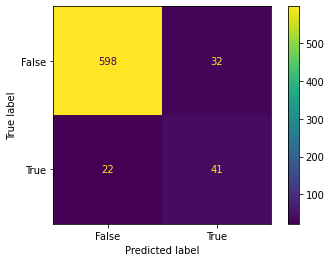

In [21]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [14]:
# TN
print(confusion_matrix[0][0])
# FN
print(confusion_matrix[1][0])
# FP
print(confusion_matrix[0][1])
# TP
print(confusion_matrix[1][1])

490
4
140
59


In [15]:
false_negative = []
false_positive = []

for threshold in np.arange(0, 0.99, 0.001):
    y_pred = []
    for i in cos_sim:
        if i > threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    false_negative.append(confusion_matrix[1][0])
    false_positive.append(confusion_matrix[0][1])
    
    if int(threshold * 100) % 100 == 0:
        print(threshold * 100)

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7000000000000001
0.8
0.9000000000000001


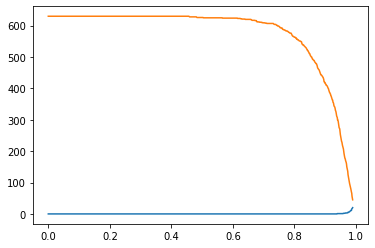

In [16]:
threshold = np.arange(0, 0.99, 0.001)
plt.plot(threshold, false_negative)
plt.plot(threshold, false_positive)
plt.show()

In [17]:
idx = (np.abs(np.array(false_negative) - np.array(false_positive))).argmin()
threshold[idx]

0.989

In [77]:
# convert keras model to tflite model

model = tf.keras.models.load_model('models/model1_cos.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open("models/model1_cos_tflite.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpf6wgkn0l\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpf6wgkn0l\assets


In [142]:
# przygotowanie zbioru testowego do tensorflowlite

data[0] = data[0].astype(np.float32)
data[1] = data[1].astype(np.float32)
data[2] = data[2].astype(np.float32)

In [143]:
# Test tflite model

import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="models/model1_cos_tflite.tflite")

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

input_data = data

preds = []
for i in range(data[0].shape[0]):
# for i in range(1):
    input_data_0 = input_data[0][i].reshape((1,
                                           input_data[0].shape[1], 
                                           input_data[0].shape[2],
                                          1))

    input_data_1 = input_data[1][i].reshape((1,
                                           input_data[1].shape[1], 
                                           input_data[1].shape[2],
                                          1))

    input_data_2 = input_data[2][i].reshape((1,
                                           input_data[2].shape[1], 
                                           input_data[2].shape[2],
                                          1))
    
    interpreter.set_tensor(input_details[0]['index'], input_data_0)
    interpreter.set_tensor(input_details[1]['index'], input_data_1)
    interpreter.set_tensor(input_details[2]['index'], input_data_2)
    
    interpreter.invoke()
    
    preds.append(interpreter.get_tensor(output_details[0]['index']))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7000000000000001
0.8
0.9000000000000001


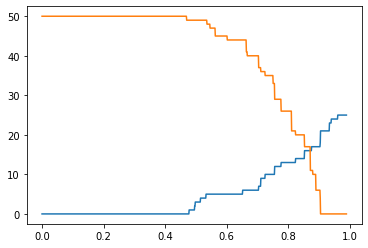

0.853


In [144]:
cos_sim = []

for pred in preds:
    anch = pred[0,:100]
    pos = pred[0,100:200]
    neg = pred[0,200:300]
    
    cos_sim.append(calc_cos_tensor(anch, pos).numpy())

false_negative = []
false_positive = []

for threshold in np.arange(0, 0.99, 0.001):
    y_pred = []
    for i in cos_sim:
        if i > threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    false_negative.append(confusion_matrix[1][0])
    false_positive.append(confusion_matrix[0][1])
    
    if int(threshold * 100) % 100 == 0:
        print(threshold * 100)
        
threshold = np.arange(0, 0.99, 0.001)
plt.plot(threshold, false_negative)
plt.plot(threshold, false_positive)
plt.show()

idx = (np.abs(np.array(false_negative) - np.array(false_positive))).argmin()
print(threshold[idx])

In [157]:
cos_sim = []

for pred in preds:
    anch = pred[0,:100]
    pos = pred[0,100:200]
    neg = pred[0,200:300]
    
    cos_sim.append(calc_cos_tensor(anch, pos).numpy())

y_pred = []
for i in cos_sim:
    if i > 0.853:
        y_pred.append(1)
    else:
        y_pred.append(0)
        
y_true = np.array(y_true)
y_pred = np.array(y_pred)

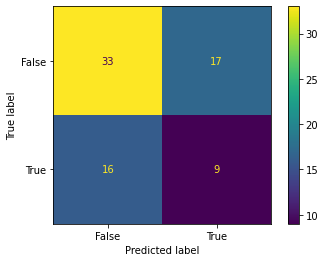

In [158]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()